# Image Clasification, Data Augumentation and Transfer learning

## Load images from dir into keras.

In [ ]:
# Start by loading images using keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale color information 0-255 to 0-1.0
data_gen = ImageDataGenerator(rescale=1.0/255)

img_dir = "a5_images"
img_size = 64
batch_size = 32

img_generator = lambda d: data_gen.flow_from_directory(
        img_dir + d,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

train_generator = img_generator("/train")
val_generator = img_generator("/validation")

Found 1600 images belonging to 2 classes.
Found 576 images belonging to 2 classes.


We can then look at this data. The code correctly prints 1 when the image is a car and 0 otherwise

(32, 64, 64, 3)


1.0

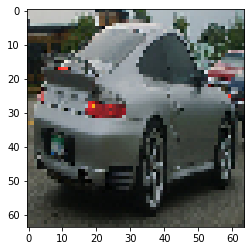

In [ ]:
import matplotlib.pyplot as plt
Xbatch, Ybatch = train_generator.next()

print( Xbatch.shape )

plt.imshow( Xbatch[0] )
Ybatch[0]

# Training the convolutional neural network

In [ ]:
import numpy as np
np.random.seed(0)

import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential

Below is a function for creating a convolutional neural network. The function is used both for the "plain" and augmented data.

In [ ]:
# This functions essentially creates the CNN from the digit classification
# example, with some small adjustments
def make_convnet(img_size):
    # This model means we just add layers 1 by 1
    model = Sequential()
    in_shape = (img_size, img_size, 3)
    num_classes = 1

    model.add(
        Conv2D(
            32,
            kernel_size=(5, 5),
            strides=(1, 1),
            activation="relu",
            input_shape=in_shape,
        )
    )
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))

    # Finish with output layer that gives us our classification,
    # sigmoid is useful for binary classification since it
    # returns a probability of the class beeing positive or not
    model.add(Dense(num_classes, activation="sigmoid"))

    # Loss and optimizer is chosen according to what is deemed to be standard for these types of problems
    model.compile(
        loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return model

In [ ]:
# Load trained weights if use_saved_weights is specified
# else train the model and store the weights in the specified path
# we also save/load the training history in/from the same path
def fit(model, train_gen, path, use_saved_weights=True, epochs=35):
    if use_saved_weights:
        model.load_weights(path + "data")
        return np.load(path + "history.npy",allow_pickle="TRUE").item()        
    history = model.fit(
        train_gen,
        epochs=epochs,
        verbose=2,
        batch_size=32,
        validation_data=val_generator,
    )
      
    model.save_weights(path + "data")
    np.save(path + "history.npy", history.history)  

    return history.history

# Helper function for loss and accuracy plots
def plot_cnn_loss_and_acc(history, epochs):
    for train, validation in [("loss", "val_loss"), ("accuracy", "val_accuracy")]:    
        plt.plot(range(epochs), history[train], label=train)
        plt.plot(range(epochs), history[validation], label=validation)
        plt.legend(loc="upper center")
        plt.xlabel("epochs")
        plt.ylabel(train)
        plt.show()

In [ ]:
cnn_model = make_convnet(img_size)
# here use_saved_weights=False will train the model and save the weights 
# in a directory called "cnn_weights"
history = fit(cnn_model, train_generator, "cnn_weights/", use_saved_weights=False)

Epoch 1/35
50/50 - 21s - loss: 0.7214 - accuracy: 0.5769 - val_loss: 0.6204 - val_accuracy: 0.6649
Epoch 2/35
50/50 - 17s - loss: 0.5900 - accuracy: 0.7013 - val_loss: 0.5727 - val_accuracy: 0.6944
Epoch 3/35
50/50 - 18s - loss: 0.4964 - accuracy: 0.7769 - val_loss: 0.5481 - val_accuracy: 0.7361
Epoch 4/35
50/50 - 18s - loss: 0.4694 - accuracy: 0.7750 - val_loss: 0.5684 - val_accuracy: 0.7188
Epoch 5/35
50/50 - 17s - loss: 0.4248 - accuracy: 0.8188 - val_loss: 0.5431 - val_accuracy: 0.7691
Epoch 6/35
50/50 - 17s - loss: 0.3482 - accuracy: 0.8537 - val_loss: 0.5726 - val_accuracy: 0.7413
Epoch 7/35
50/50 - 17s - loss: 0.3082 - accuracy: 0.8675 - val_loss: 0.5709 - val_accuracy: 0.7639
Epoch 8/35
50/50 - 17s - loss: 0.2135 - accuracy: 0.9137 - val_loss: 0.6047 - val_accuracy: 0.7795
Epoch 9/35
50/50 - 17s - loss: 0.1775 - accuracy: 0.9325 - val_loss: 0.7911 - val_accuracy: 0.7483
Epoch 10/35
50/50 - 17s - loss: 0.1637 - accuracy: 0.9413 - val_loss: 0.6966 - val_accuracy: 0.7639
Epoch 11/

## Accuracy and binary-crossentropy loss of the model.

As training proceeds the model overfits for plain data. Validation accuracy does not increase as training accuracy approaches 1. The loss trends the same way, increasing for validation data and decresing for training data.

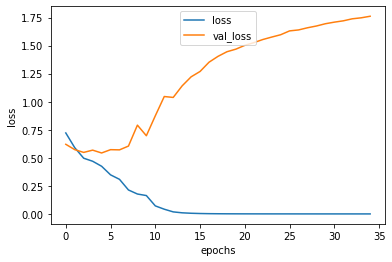

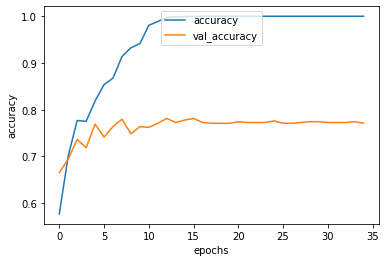

In [ ]:
plot_cnn_loss_and_acc(history, 35)

# Data augmentation
Here we use data augmentation in an attempt to reduce overfitting, we haven't performed extensive testing as to what data augumentation is the best but even with these randomly picked parameters we can see a significant improvement.

In [ ]:
# Augumented data generator
data_aug_gen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    channel_shift_range=0.5,
    zoom_range=0.2
)

# Augumented data generator with training data
train_aug_generator = data_aug_gen.flow_from_directory(
        img_dir + "/train",
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Found 1600 images belonging to 2 classes.


In [ ]:
cnn_aug_model = make_convnet(img_size)
# here use_saved_weights=False will train the model and save the weights 
# in a directory called "cnn_aug_weights"
history_aug = fit(cnn_aug_model, train_aug_generator, "cnn_aug_weights/", use_saved_weights=False)

Epoch 1/35
50/50 - 21s - loss: 0.6786 - accuracy: 0.5850 - val_loss: 0.6287 - val_accuracy: 0.6771
Epoch 2/35
50/50 - 20s - loss: 0.6175 - accuracy: 0.6712 - val_loss: 0.5862 - val_accuracy: 0.7101
Epoch 3/35
50/50 - 20s - loss: 0.5904 - accuracy: 0.6994 - val_loss: 0.5848 - val_accuracy: 0.7135
Epoch 4/35
50/50 - 19s - loss: 0.5703 - accuracy: 0.7175 - val_loss: 0.5529 - val_accuracy: 0.7361
Epoch 5/35
50/50 - 20s - loss: 0.5733 - accuracy: 0.7150 - val_loss: 0.5596 - val_accuracy: 0.7135
Epoch 6/35
50/50 - 20s - loss: 0.5374 - accuracy: 0.7344 - val_loss: 0.5658 - val_accuracy: 0.7222
Epoch 7/35
50/50 - 20s - loss: 0.5419 - accuracy: 0.7375 - val_loss: 0.5203 - val_accuracy: 0.7535
Epoch 8/35
50/50 - 20s - loss: 0.5376 - accuracy: 0.7369 - val_loss: 0.5228 - val_accuracy: 0.7517
Epoch 9/35
50/50 - 20s - loss: 0.5217 - accuracy: 0.7387 - val_loss: 0.5141 - val_accuracy: 0.7778
Epoch 10/35
50/50 - 20s - loss: 0.5605 - accuracy: 0.7262 - val_loss: 0.5851 - val_accuracy: 0.7396
Epoch 11/

## Including augmented data seems to effectively mitigate overfitting.
However, it learns slower. When comparing the models we can see a significant reduction in loss but the validation accuracy doesn't seem to improve much. We interpret this as this model being more confident in its decisions as compared to the model trained on plain data. Thus the second model gives stronger indications for the right predictions and smaller indications for the incorrect predictions.

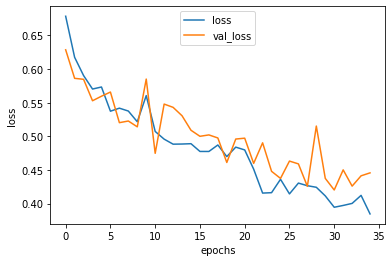

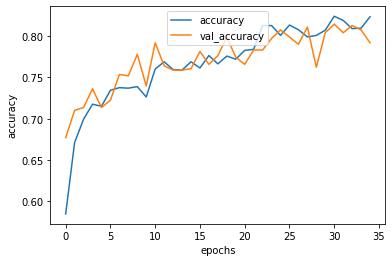

In [ ]:
plot_cnn_loss_and_acc(history_aug, 35)

## Interlude: Applying a pre-trained convolutional neural network
We download the vgg-16 model and use it to predict an instance from our dataset

In [ ]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input
import matplotlib.pyplot as plt
import numpy as np

vggmodel = applications.VGG16(weights='imagenet', include_top=True)

553467904/553467096 [==============================] - 3s 0us/step


40960/35363 [==================================] - 0s 0us/step
[[['n02690373' 'airliner' '0.51631373']
  ['n04552348' 'warplane' '0.13855612']
  ['n04592741' 'wing' '0.09494321']
  ['n03344393' 'fireboat' '0.06282501']
  ['n04266014' 'space_shuttle' '0.037961584']]]


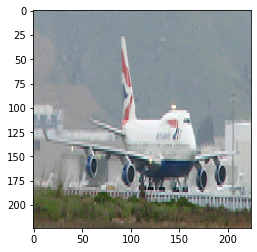

In [ ]:
airplane_image = load_img("a5_images/train/other/0010.jpg", target_size=(224,224))

plt.imshow(airplane_image)
airplane_array = img_to_array( airplane_image )

# Preprocess using vgg16 fkn and reshape
airplane_procd = preprocess_input( airplane_array )
airplane_procd = airplane_procd.reshape(1, 224, 224, 3)

airplane_answer = decode_predictions( vggmodel.predict( airplane_procd ) )
print( np.array(airplane_answer))



# Using VGG-16 as a feature extractor

In [ ]:
# Note img_size is 64 from first block
feature_extractor = applications.VGG16(include_top=False, weights='imagenet',
                                       input_shape=(img_size, img_size, 3))

vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)


def create_vgg16_features(in_path, out_path):
    gen = vgg_data_gen.flow_from_directory(
        img_dir + in_path,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=False)

    feats = feature_extractor.predict( gen )

    with open(out_path, 'wb') as f:
        np.save(f, feats)

create_vgg16_features("/train", "train_feats.dat")
create_vgg16_features("/validation", "val_feats.dat")


58892288/58889256 [==============================] - 0s 0us/step
Found 1600 images belonging to 2 classes.
Found 576 images belonging to 2 classes.


In [ ]:
# Helper function to get labels for data, assumes first half of data
# is of one type, second of other type
def get_labels(n):
    return np.array([0]*(n//2) + [1]*(n//2))

# Takes a classifier as input and trains it on features
# generated by the amazing VGG16 network
def train_on_cnnfeatures( classifier, epochs=20 ): 
    with open("./train_feats.dat", 'rb') as f:
        train_data = np.load(f)
    with open("./val_feats.dat", 'rb') as f:
        val_data = np.load(f)    

    train_labels =  get_labels(1600)
    val_labels = get_labels(576)

    history = classifier.fit(
        train_data,
        train_labels,
        epochs=epochs,
        verbose=2,
        batch_size=32,
        validation_data=(val_data, val_labels),
    )    

    return history.history

# Model to be run on top of VGG-16
def make_keras_clf():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        loss="binary_crossentropy", 
        optimizer="adam", 
        metrics=["accuracy"]
    )

    return model

Running the above keras model on top of VGG16 gives superior performance from the 1st epoch onwards! Thus we make successful use of transfer learning. Whoo

Epoch 1/20
50/50 - 1s - loss: 2.1696 - accuracy: 0.8481 - val_loss: 1.2638 - val_accuracy: 0.8646
Epoch 2/20
50/50 - 0s - loss: 0.1823 - accuracy: 0.9606 - val_loss: 0.9204 - val_accuracy: 0.8785
Epoch 3/20
50/50 - 0s - loss: 0.0308 - accuracy: 0.9900 - val_loss: 0.8860 - val_accuracy: 0.8837
Epoch 4/20
50/50 - 0s - loss: 0.0118 - accuracy: 0.9956 - val_loss: 0.7944 - val_accuracy: 0.8837
Epoch 5/20
50/50 - 0s - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.8015 - val_accuracy: 0.8819
Epoch 6/20
50/50 - 0s - loss: 3.0967e-04 - accuracy: 1.0000 - val_loss: 0.8061 - val_accuracy: 0.8819
Epoch 7/20
50/50 - 0s - loss: 2.3176e-04 - accuracy: 1.0000 - val_loss: 0.8082 - val_accuracy: 0.8819
Epoch 8/20
50/50 - 0s - loss: 1.9482e-04 - accuracy: 1.0000 - val_loss: 0.8114 - val_accuracy: 0.8819
Epoch 9/20
50/50 - 0s - loss: 1.6850e-04 - accuracy: 1.0000 - val_loss: 0.8153 - val_accuracy: 0.8837
Epoch 10/20
50/50 - 0s - loss: 1.4779e-04 - accuracy: 1.0000 - val_loss: 0.8184 - val_accuracy: 0.8837

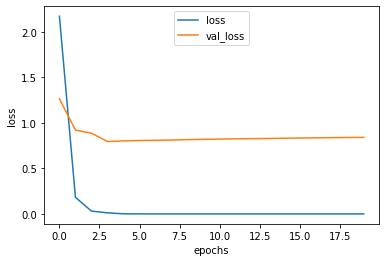

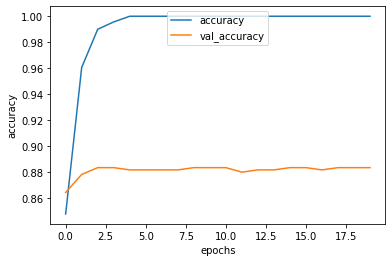

In [ ]:
keras_clf = make_keras_clf()

history_transfer = train_on_cnnfeatures( keras_clf, epochs=20)

plot_cnn_loss_and_acc(history_transfer, 20)

# Visualizing the learned features

In [ ]:
first_layer_weights_vgg = vggmodel.get_weights()[0]
first_layer_weights = cnn_aug_model.get_weights()[0]

def kernel_image(weights, i, positive):
    
    # extract the convolutional kernel at position i
    k = weights[:,:,:,i].copy()
    if not positive:
        k = -k
    
    # clip the values: if we're looking for positive
    # values, just keep the positive part; vice versa
    # for the negative values.
    k *= k > 0

    # rescale the colors, to make the images less dark
    m = k.max()
    if m > 1e-3:
        k /= m 

    return k

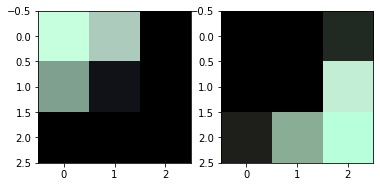

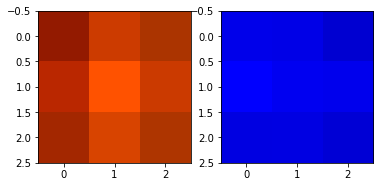

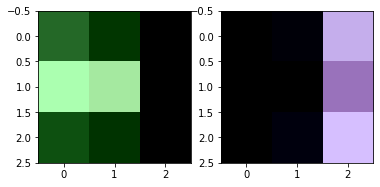

In [ ]:
# Print the first 3 filters (both positive and negative) in the first layer of our vgg based model
for i in range(3):
    f, ax = plt.subplots(1,2)
    ax[0].imshow(kernel_image( first_layer_weights_vgg, i, True))
    ax[1].imshow(kernel_image( first_layer_weights_vgg, i, False))
    plt.show()

By looking at the first filter plot (left picture) we can see that the filter detects a gradient from (light blue) top left to (dark) bottom right. Plot 2 (left picture) detects a brown-ish color and plot 3 (left picture) detects a green color gradient from (light) left to (dark) right.

From this we can see that the filters overall seems to identify rudimentaty shapes, lines, gradients and colors.

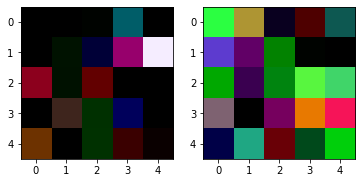

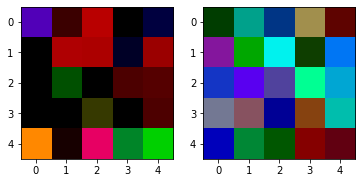

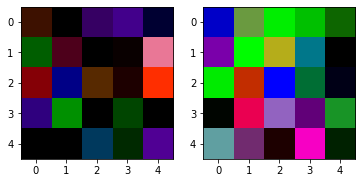

In [ ]:
for i in range(3):
    f, ax = plt.subplots(1,2)
    ax[0].imshow(kernel_image( first_layer_weights, i, True))
    ax[1].imshow(kernel_image( first_layer_weights, i, False))
    plt.show()

When doing the same for our model we get a less interpretable result as expected and it is hard to tell what each filter focuses on in each plot. This may be due to it being a more niched model with a smaller dataset which makes the lowest filters less general and more specific for this application. 